# Create a workflow for the Kaggle Titanic competition

In [2]:
# import the data
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(3)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def clean(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df,"Age_categories")
    df = create_dummies(df,"Fare_categories")
    df = create_dummies(df,"Title")
    df = create_dummies(df,"Cabin_type")
    df = create_dummies(df,"Sex")
    return df

train = clean(train)
holdout = clean(holdout)

In [5]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [6]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

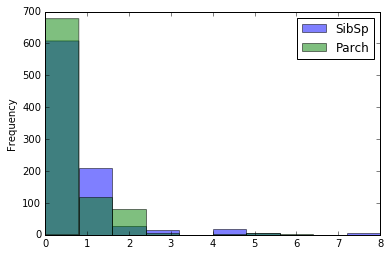

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(1)
train[['SibSp', 'Parch']].plot.hist(alpha=0.5)

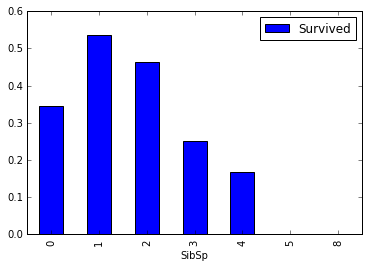

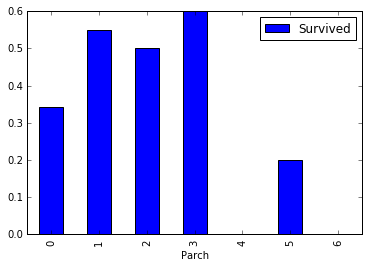

In [8]:
pivot = train.pivot_table(values='Survived', index='SibSp')
fig = plt.figure(2)
pivot.plot.bar()

pivot2 = train.pivot_table(values='Survived', index='Parch')
fig2 = plt.figure(3)
pivot2.plot.bar()

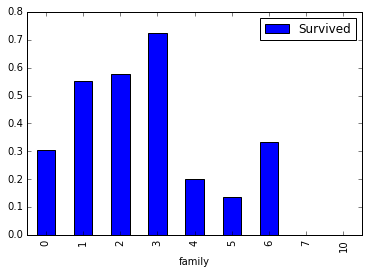

In [9]:
train['family'] = train['SibSp']+train['Parch']
pivot3 = train.pivot_table(values='Survived', index='family')
fig4 = plt.figure(4)
pivot3.plot.bar()
train.drop('family', axis=1, inplace=True)

### People with 1-3 family members on board have higher chance of survival. What about grouping passenger by whether or not having any family member on board. 

In [10]:
def familyornot(df):
    df['family'] = df['SibSp'] + df['Parch']
    df['isalone'] = [0 if x==0 else 1 for x in df['family']]
    df.drop('family', axis=1, inplace=True)
    return df

train = familyornot(train)
holdout = familyornot(holdout)


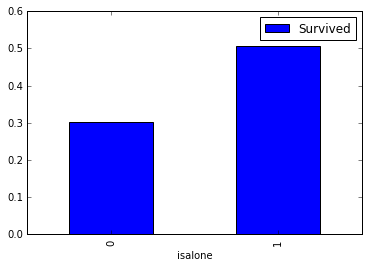

In [11]:
pivot4 = train.pivot_table(values='Survived', index='isalone')
fig5 = plt.figure(5)
pivot4.plot.bar()


### People with one or more family member on board had 20% more likelihood of survival than people who were alone.

In [12]:
train.info()
temp = train.select_dtypes(exclude='object')
temp.info()
temp.isnull().sum()
feature_cols = temp.columns[7:]
all_X = train[feature_cols]
all_y = train['Survived']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    feature_cols = df.select_dtypes(include='uint8').columns
    print(feature_cols)
    all_X = df[feature_cols]
    print(all_X.info())
    all_y = df['Survived']
    model = RandomForestClassifier(random_state=1)
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)
    best_cols = feature_cols[selector.support_]
    print(best_cols)
    return best_cols

best_feature_cols = select_features(train)    
    

Index(['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uint8
Age_categories_Teenager       891 non-null uint8
Age_categories_Young Adult    891 non-null uint8
Age_categori

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


### Best feature columns turn out to be only 4: 'Title_Mr', 'Title_Mrs', 'Cabin_type_Unknown', 'Sex_female'. Check correlation coefficient with 'Survived' and confirm

In [14]:
train_X = train[train.select_dtypes(include='uint8').columns]
train_y = train['Survived']
train_Xy = pd.concat([train_X, train_y], axis=1)
train_Xy.corr()['Survived'].sort_values()

Title_Mr                     -0.549199
Sex_male                     -0.543351
Cabin_type_Unknown           -0.316912
Fare_categories_0-12         -0.287849
Age_categories_Missing       -0.092197
Age_categories_Senior        -0.051224
Title_Officer                -0.031316
Cabin_type_T                 -0.026456
Age_categories_Child         -0.008328
Age_categories_Young Adult   -0.001949
Cabin_type_G                  0.016040
Age_categories_Adult          0.017590
Cabin_type_A                  0.022287
Age_categories_Teenager       0.026859
Title_Royalty                 0.033391
Cabin_type_F                  0.057935
Fare_categories_12-50         0.065790
Title_Master                  0.085221
Cabin_type_C                  0.114652
Cabin_type_E                  0.145321
Age_categories_Infant         0.150304
Cabin_type_D                  0.150716
Cabin_type_B                  0.175095
Fare_categories_100+          0.182033
Fare_categories_50-100        0.205384
Title_Miss               

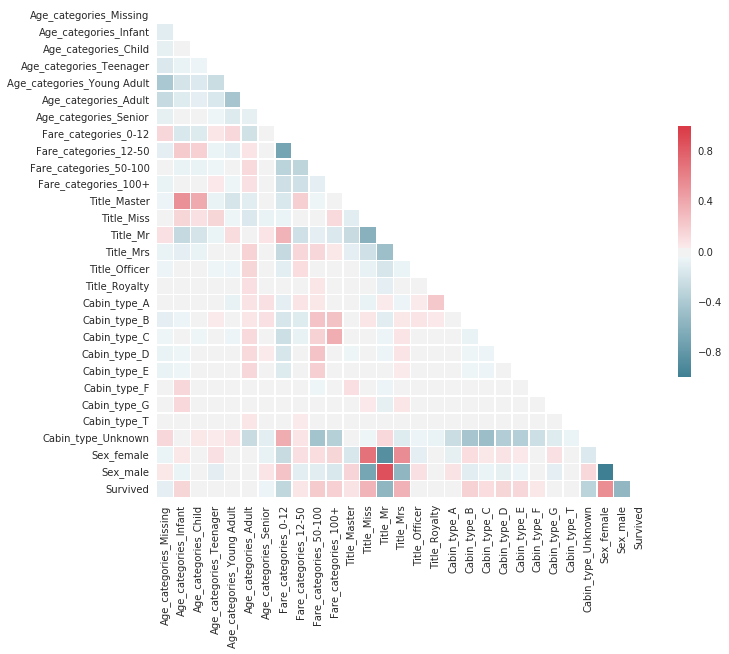

In [16]:
import seaborn as sns
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(train_Xy)


## Hyperparameter optimization

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, feature_cols):
    all_X = df[feature_cols]
    all_y = df['Survived']
    dict_list = [{'name': 'LogisticRegression',
                  'estimator': LogisticRegression(),
                 'hyperparameters':
                     {"solver": ["newton-cg", "lbfgs", "liblinear"]
                     } 
                }, 
                 {'name': 'KNeighborsClassifier',
                  'estimator': KNeighborsClassifier(),
                 'hyperparameters':
                      {"n_neighbors": range(1,20,2),
                       "weights": ["distance", "uniform"],
                       "algorithm": ["ball_tree", "kd_tree", "brute"],
                       "p": [1,2],
                       }
                 },
                 {'name': 'RandomForestClassifier',
                  'estimator': RandomForestClassifier(),
                  'hyperparameters':
                      {"n_estimators": [4, 6, 9],
                       "criterion": ["entropy", "gini"],
                       "max_depth": [2, 5, 10],
                       "max_features": ["log2", "sqrt"],
                       "min_samples_leaf": [1, 5, 8],
                       "min_samples_split": [2, 3, 5]                          
                      }                     
                 }]
    for item in dict_list:
        model = item['name']
        print(model)
        grid = GridSearchCV(item['estimator'], param_grid=item['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        item['best_param'] = grid.best_params_
        item['best_score'] = grid.best_score_
        print(item['best_param'])
        print(item['best_score'])
    return dict_list

best_models = select_model(train, best_feature_cols)
    

LogisticRegression
{'solver': 'newton-cg'}
0.7957351290684624
KNeighborsClassifier
{'weights': 'distance', 'p': 1, 'algorithm': 'ball_tree', 'n_neighbors': 11}
0.7912457912457912
RandomForestClassifier
{'min_samples_split': 5, 'n_estimators': 6, 'max_depth': 2, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_features': 'log2'}
0.7968574635241302


In [54]:
best_models[2]['estimator']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### The best model is RandomForest and it gives an accuracy score of 0.7968 for the trainig set. 

## Apply this model on holdout set and submit results to Kaggle

In [58]:
def save_submission_file(model, cols, file):
    model.fit(train[cols], train['Survived'])
    predictions = model.predict(holdout[cols])
    submission = pd.DataFrame()
    submission['PassengerId'] = holdout['PassengerId']
    submission['Survived'] = predictions
    submission.to_csv(file, index=False)

# find the best model

save_submission_file(best_models[2]['estimator'], best_feature_cols, 'sub_Titanic_JayZhu.csv')